In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Conv2D , GlobalAveragePooling2D,Input , Dense ,BatchNormalization , Dropout , AveragePooling2D,MaxPool2D
from tensorflow.keras.models import load_model , save_model , Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping ,ModelCheckpoint
from tensorflow.keras.optimizers import Adam , SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
folder_dir = 'C:/Users/varghese.jacob/Documents/Data Structures/flowers'

In [3]:
#Loading the files
data = []
label = []

SIZE = 96 #Crop the image to 80x80

for folder in os.listdir(folder_dir):
    for file in os.listdir(os.path.join(folder_dir, folder)):
        if file.endswith("jpg"):
            label.append(folder)
            img = cv2.imread(os.path.join(folder_dir, folder, file))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im = cv2.resize(img_rgb, (SIZE,SIZE))
            data.append(im)
        else:
            continue

In [4]:
data=np.array(data)
label=np.array(label)

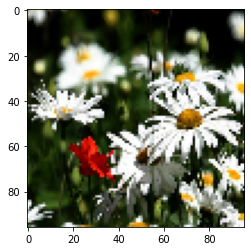

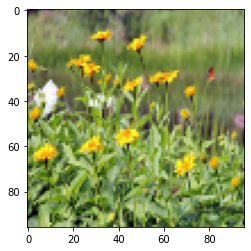

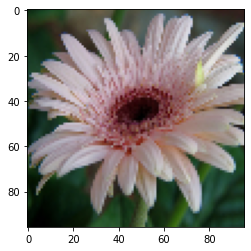

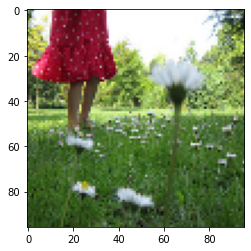

In [5]:
#Just few images
for i in range(0,4):
    plt.imshow(data[i])
    plt.show()

In [6]:
#Add noise to see how it tempered loss works

def add_gaussian_noise(images, mean=0, std=10):
    noisy_images = []
    for image in images:
        noise = np.random.normal(mean, std, image.shape)
        noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
        noisy_images.append(noisy_image)
    return np.array(noisy_images)


In [7]:
noisy_data = add_gaussian_noise(data)


In [8]:
#the labels should be converted
encode=LabelEncoder()
Y=encode.fit_transform(label)
Y=to_categorical(Y,5)

In [9]:
X=noisy_data
print(X.shape)
print(Y.shape)

(4312, 96, 96, 3)
(4312, 5)


In [10]:
#splitting the data
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,random_state=100,test_size=0.25)

In [11]:
#To prevent overfitting
datagen = ImageDataGenerator(
        rescale=1/255,
                           horizontal_flip=True,
                           vertical_flip=True,
                           shear_range=0.2,
                           zoom_range=0.2,
                           fill_mode='nearest',
                           height_shift_range=0.2,
                           width_shift_range=0.2,
                           rotation_range=0.2
)

datagen.fit(xtrain)

In [13]:
from tensorflow.keras.applications import MobileNetV2

In [14]:
def create_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    return model


In [15]:
model = create_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)


history = model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=len(xtrain) // 32,
                    epochs=100,
                    validation_data=(xtest / 255, ytest),
                    callbacks=[early_stopping])



Epoch 1/100
101/101 [==============================] - 22s 199ms/step - loss: 1.2994 - accuracy: 0.4997 - val_loss: 0.6946 - val_accuracy: 0.7570
Epoch 2/100
101/101 [==============================] - 20s 197ms/step - loss: 0.8507 - accuracy: 0.6768 - val_loss: 0.6102 - val_accuracy: 0.7885
Epoch 3/100
101/101 [==============================] - 19s 192ms/step - loss: 0.7705 - accuracy: 0.7080 - val_loss: 0.5699 - val_accuracy: 0.8015
Epoch 4/100
101/101 [==============================] - 21s 207ms/step - loss: 0.6848 - accuracy: 0.7489 - val_loss: 0.5508 - val_accuracy: 0.7996
Epoch 5/100
101/101 [==============================] - 21s 209ms/step - loss: 0.6641 - accuracy: 0.7545 - val_loss: 0.5364 - val_accuracy: 0.8015
Epoch 6/100
101/101 [==============================] - 21s 204ms/step - loss: 0.6077 - accuracy: 0.7811 - val_loss: 0.5427 - val_accuracy: 0.8089
Epoch 7/100
101/101 [==============================] - 21s 211ms/step - loss: 0.5895 - accuracy: 0.7804 - val_loss: 0.5397 -

In [16]:
model.evaluate(xtest / 255, ytest)


34/34 [==============================] - 5s 132ms/step - loss: 0.4573 - accuracy: 0.8237


[0.45730701088905334, 0.8237476944923401]